In [2]:
%load_ext autoreload
%autoreload 2

import os, sys
from tqdm import tqdm
import time
import torch
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pickle
from pathlib import Path
from glob import glob

from scipy.stats import normaltest
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import FastICA

sys.path.append("../") 
from sparsenet.ImageDataset import NatPatchDataset
from sparsenet.atlSparseNet import SparseNet, argsSparseNet
from sparsenet.plotting import plot_rf
from sparsenet import snExperiments as snExperiments

In [2]:
arg=argsSparseNet()
print(arg.__dict__)

{'batch_size': 2000, 'n_neuron': 400, 'size': 10, 'epoch': 100, 'learning_rate': 0.01, 'r_learning_rate': 0.01, 'reg': 0.005}


In [3]:
# save to tensorboard
# board = SummaryWriter("./runs/sparse-net")    
opts={'learning_rate':1e-2,'n_neuron':400,'epoch':12}
arg = argsSparseNet(opts) # Defaults encoded in class
# if use cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# create net
sparse_net = SparseNet(arg.n_neuron, arg.size, R_lr=arg.r_learning_rate, lmda=arg.reg, device=device)
# load data
batch_size = 500
dataloader = DataLoader(NatPatchDataset(arg.batch_size, arg.size, arg.size, fpath='./data/IMAGES.mat'), batch_size=batch_size, shuffle=True)
# train
optim = torch.optim.SGD([{'params': sparse_net.U.weight, "lr": arg.learning_rate}])

# track loss & measure integration
frac2remove = 0.25
num2remove = int(arg.n_neuron*frac2remove)
trackLoss = torch.zeros(arg.epoch*len(dataloader))
woutHiAlignLoss = torch.zeros(arg.epoch*len(dataloader))
woutLoAlignLoss = torch.zeros(arg.epoch*len(dataloader))
alignMean = torch.zeros((arg.n_neuron,arg.epoch*len(dataloader)))
useForSmall = int(batch_size/4)
batchIdx = 0
for e in tqdm(range(arg.epoch)):
    running_loss = 0
    c = 0
    for img_batch in dataloader: #tqdm(dataloader, desc='training', total=len(dataloader)):
        img_batch = torch.flatten(img_batch,1).to(device)
        # update
        pred = sparse_net(img_batch)
        loss = ((img_batch - pred) ** 2).sum()
        running_loss += loss.item()
        loss.backward()
        # update U
        optim.step()
        # zero grad
        sparse_net.zero_grad()
        # norm
        sparse_net.normalize_weights()
        # save values
        trackLoss[batchIdx]=loss.item()
        alignMean[:,batchIdx]=sparse_net.measureAlignment(img_batch)
        idxCurrentAlign = torch.argsort(alignMean[:,batchIdx])
        idxWoutHi = idxCurrentAlign[:-num2remove]
        idxWoutLo = idxCurrentAlign[num2remove:]
        woutHiPred = sparse_net.forwardSubsetReuse(img_batch, idxWoutHi)
        woutLoPred = sparse_net.forwardSubsetReuse(img_batch, idxWoutLo)
        woutHiAlignLoss[batchIdx] = ((img_batch-woutHiPred)**2).sum().detach()
        woutLoAlignLoss[batchIdx] = ((img_batch-woutLoPred)**2).sum().detach()
        c += 1
        batchIdx += 1
    # And update occasionally
    #if e%5==4:
    #    fig = plot_rf(sparse_net.U.weight.T.reshape(arg.n_neuron, arg.size, arg.size).cpu().data.numpy(), arg.n_neuron, arg.size)

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:09<00:00,  1.21it/s]


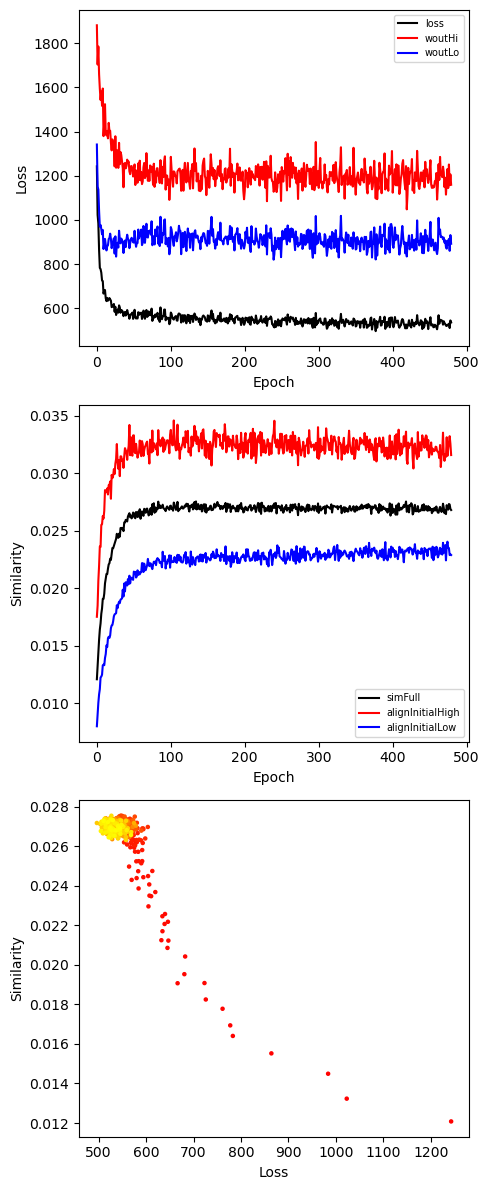

In [4]:
idxInitAlign = torch.argsort(alignMean[:,0])
num2look = 50
highInit = idxInitAlign[-num2look:]
lowInit = idxInitAlign[:num2look]
fig,ax = plt.subplots(3,1,figsize=(5,12))
ax[0].plot(range(arg.epoch*len(dataloader)), trackLoss, c='k', label='loss')
ax[0].plot(range(arg.epoch*len(dataloader)), woutHiAlignLoss.detach(), c='r', label='woutHi')
ax[0].plot(range(arg.epoch*len(dataloader)), woutLoAlignLoss.detach(), c='b', label='woutLo')

# Plot Similarity
ax[1].plot(range(arg.epoch*len(dataloader)), torch.mean(alignMean,axis=0), c='k', label='simFull')
ax[1].plot(range(arg.epoch*len(dataloader)), torch.mean(alignMean[highInit,:],axis=0), c='r', label='alignInitialHigh')
ax[1].plot(range(arg.epoch*len(dataloader)), torch.mean(alignMean[lowInit,:],axis=0), c='b', label='alignInitialLow')

for i in range(2):
    ax[i].set_xlabel('Epoch')
    ax[i].legend(fontsize=7)
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Similarity')

ax[2].scatter(trackLoss, torch.mean(alignMean,axis=0), c=range(len(trackLoss)), cmap='autumn', s=5)
ax[2].set_xlabel('Loss')
ax[2].set_ylabel('Similarity')
plt.tight_layout()

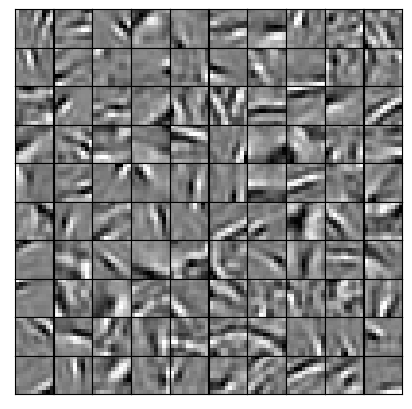

In [6]:
rfs = sparse_net.U.weight.T.reshape(arg.n_neuron, arg.size, arg.size).cpu().data.numpy()
fig = plot_rf(rfs, arg.n_neuron, arg.size, showRFs=10**2)

In [12]:
# Measure eigenvectors of images
allImages = []
for img_batch in dataloader:
    allImages.append(torch.flatten(img_batch,1))
allImages = torch.cat(allImages)
imCov = torch.cov(allImages.T)
imEval,imEvec = torch.linalg.eigh(imCov)
imEval,idxEval = torch.sort(imEval, descending=True)
imEvec = imEvec[:,idxEval]
NEV = len(imEval)

# Measure dot product of RFs on eigenvectors
rfs = sparse_net.U.weight.clone().cpu().detach()
rfs = rfs / torch.norm(rfs,dim=0) # make sure they are normed!
beta = torch.abs(imEvec.T @ rfs)

# Measure dot product of RFs on images
rfActivation = allImages @ rfs

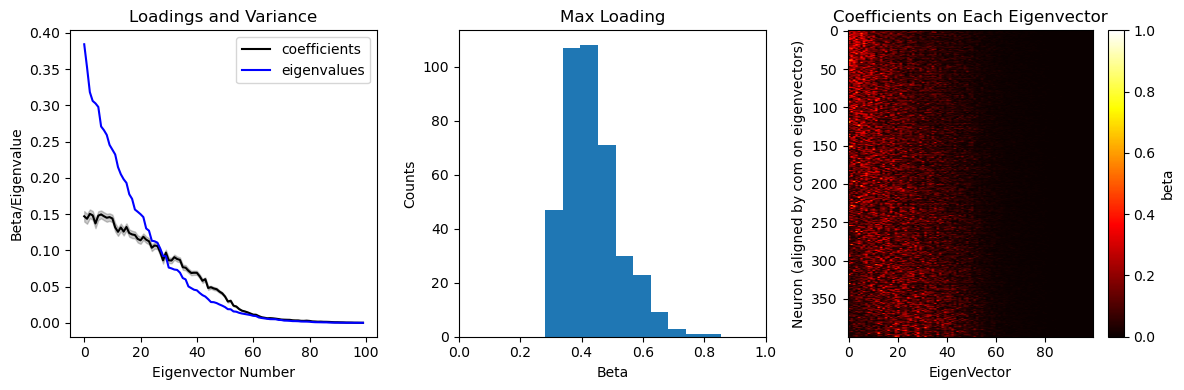

In [13]:
# Make summary plots of betas
fig,ax = plt.subplots(1,3,figsize=(12,4))

# Plot betas
mnBeta = torch.mean(beta, dim=1)
seBeta = torch.std(beta, dim=1)/np.sqrt(beta.shape[1])
# plt.plot(range(NEV), beta, c='lightgrey', linewidth=0.2, alpha=0.1)
ax[0].plot(range(NEV), torch.mean(beta, dim=1), c='k', linewidth=1.5, label='coefficients')
ax[0].fill_between(range(NEV), mnBeta+seBeta, mnBeta-seBeta, color='k', alpha=0.2)
ax[0].plot(range(NEV), imEval, c='b', label='eigenvalues')
ax[0].legend()
ax[0].set_xlabel('Eigenvector Number')
ax[0].set_ylabel('Beta/Eigenvalue')
ax[0].set_title('Loadings and Variance')

# Plot histogram of maximum beta
maxBeta = torch.max(beta,dim=0)[0]
ax[1].hist(maxBeta.numpy())
ax[1].set_xlim(0,1)
ax[1].set_xlabel('Beta')
ax[1].set_ylabel('Counts')
ax[1].set_title('Max Loading')

# Plot heatmap of all coefficients (sorted by COM)
use2sort = 'eval'
comVals = imEval if use2sort=='eval' else np.arange(NEV)
comBeta = (comVals @ beta.numpy()) / torch.sum(beta * beta, dim=0)
idxComBeta = torch.argsort(comBeta,descending=True)
hm=ax[2].imshow(beta[:,idxComBeta].T,aspect='auto', cmap='hot', vmin=0, vmax=1)
ax[2].set_xlabel('EigenVector')
ax[2].set_ylabel('Neuron (aligned by com on eigenvectors)')
ax[2].set_title('Coefficients on Each Eigenvector')
plt.colorbar(hm, ax=ax[2], label='beta')

# Make it pretty
plt.tight_layout()


# Compare entropy of betas to similarity
normBeta = beta/torch.sum(beta,dim=0)
entropy = -torch.nansum(normBeta * torch.log2(beta),dim=0)
# plt.hist(entropy.numpy())

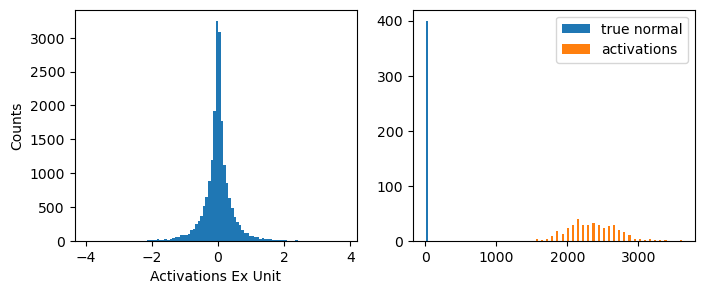

In [179]:
stat0,p0 = normaltest(np.random.normal(0,1,rfActivation.shape),axis=0)
stat,p = normaltest(rfActivation,axis=0)

fig,ax = plt.subplots(1,2,figsize=(8,3))
# Plot example activations
ax[0].hist(rfActivation[:,1].numpy(), bins=100)
ax[0].set_xlabel('Activations Ex Unit')
ax[0].set_ylabel('Counts')

# Compare distribution of stats with true normal
ax[1].hist([stat0,stat], bins=50, label=['true normal','activations']);
ax[1].legend()

In [34]:
ica.components_.shape

(100, 100)

In [91]:
ica = FastICA(n_components=40,max_iter=500, whiten="arbitrary-variance", tol=15e-5)
ica.fit(allImages)
components = ica.components_

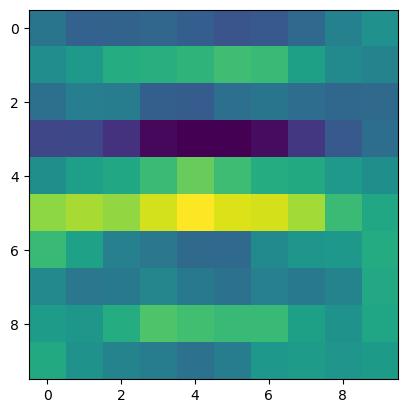

In [92]:
plt.imshow(components[0,:].reshape(10,10))

In [93]:
# Perform many runs
epochs = 100
learningRate = (1e-2, 1e-3, 7e-4, 3e-4)
numRuns = 10
numLR = len(learningRate)

doMultipleRuns = False
if doMultipleRuns:
    # Do Runs
    for lr in range(numLR):
        opts={'learning_rate':learningRate[lr],'n_neuron':400,'epoch':epochs}
        for runIdx in range(numRuns):
            print(f"Learning Rate: {lr+1}/{numLR}, Run: {runIdx+1}/{numRuns}...")
            results = snExperiments.mainExperiment(opts)
            # And Save
            saveDir=Path('results/firstPassSparsenet')
            fileName=f'sparseNet{runIdx}_LR{lr}.pkl'
            with open(saveDir / fileName, 'wb') as f:
                pickle.dump(results, f)

Learning Rate: 1/4, Run: 1/10...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:24<00:00,  1.19it/s]


Learning Rate: 1/4, Run: 2/10...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:23<00:00,  1.20it/s]


Learning Rate: 1/4, Run: 3/10...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:23<00:00,  1.20it/s]


Learning Rate: 1/4, Run: 4/10...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.30it/s]


Learning Rate: 1/4, Run: 5/10...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.30it/s]


Learning Rate: 1/4, Run: 6/10...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.30it/s]


Learning Rate: 1/4, Run: 7/10...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.30it/s]


Learning Rate: 1/4, Run: 8/10...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.30it/s]


Learning Rate: 1/4, Run: 9/10...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:15<00:00,  1.32it/s]


Learning Rate: 1/4, Run: 10/10...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:17<00:00,  1.29it/s]


Learning Rate: 2/4, Run: 1/10...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.31it/s]


Learning Rate: 2/4, Run: 2/10...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.31it/s]


Learning Rate: 2/4, Run: 3/10...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.30it/s]


Learning Rate: 2/4, Run: 4/10...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.30it/s]


Learning Rate: 2/4, Run: 5/10...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.30it/s]


Learning Rate: 2/4, Run: 6/10...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.30it/s]


Learning Rate: 2/4, Run: 7/10...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.30it/s]


Learning Rate: 2/4, Run: 8/10...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.30it/s]


Learning Rate: 2/4, Run: 9/10...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.30it/s]


Learning Rate: 2/4, Run: 10/10...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.30it/s]


Learning Rate: 3/4, Run: 1/10...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.30it/s]


Learning Rate: 3/4, Run: 2/10...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.30it/s]


Learning Rate: 3/4, Run: 3/10...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:17<00:00,  1.30it/s]


Learning Rate: 3/4, Run: 4/10...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.30it/s]


Learning Rate: 3/4, Run: 5/10...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.30it/s]


Learning Rate: 3/4, Run: 6/10...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.30it/s]


Learning Rate: 3/4, Run: 7/10...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.30it/s]


Learning Rate: 3/4, Run: 8/10...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.30it/s]


Learning Rate: 3/4, Run: 9/10...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.31it/s]


Learning Rate: 3/4, Run: 10/10...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.30it/s]


Learning Rate: 4/4, Run: 1/10...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.31it/s]


Learning Rate: 4/4, Run: 2/10...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.31it/s]


Learning Rate: 4/4, Run: 3/10...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:17<00:00,  1.30it/s]


Learning Rate: 4/4, Run: 4/10...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.31it/s]


Learning Rate: 4/4, Run: 5/10...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.31it/s]


Learning Rate: 4/4, Run: 6/10...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.31it/s]


Learning Rate: 4/4, Run: 7/10...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.31it/s]


Learning Rate: 4/4, Run: 8/10...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.31it/s]


Learning Rate: 4/4, Run: 9/10...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.31it/s]


Learning Rate: 4/4, Run: 10/10...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.31it/s]


In [202]:
# Analyze multiple runs 
saveDir=Path('results/firstPassSparsenet')
fileNames = glob("./results/firstPassSparsenet/*.pkl")

nets = []
trackLoss = []
noHiLoss = []
noLoLoss = []
alignment = []
learningRate = []
for file in fileNames:
    with open(file, 'rb') as f:
        results = pickle.load(f)
        nets.append(results['sparse_net'])
        trackLoss.append(results['trackLoss'])
        alignment.append(results['alignMean'])
        noHiLoss.append(results['woutHiAlignLoss'])
        noLoLoss.append(results['woutLoAlignLoss'])
        learningRate.append(results['arg'].learning_rate)
learningRate = np.array(learningRate)
lrVals = np.unique(learningRate)
NLR = len(lrVals)

# Just for the reminder...
print(lrVals)
print(f"Keys available from results dictionary: {results.keys()}")

# Get better formatted summary statistics 
print(len(trackLoss))
print(len(alignment))
print(alignment[0].shape)

[0.0003 0.0007 0.001  0.01  ]
Keys available from results dictionary: dict_keys(['arg', 'sparse_net', 'dataloader', 'optim', 'frac2remove', 'trackLoss', 'woutHiAlignLoss', 'woutLoAlignLoss', 'alignMean'])
40
40
torch.Size([400, 4000])


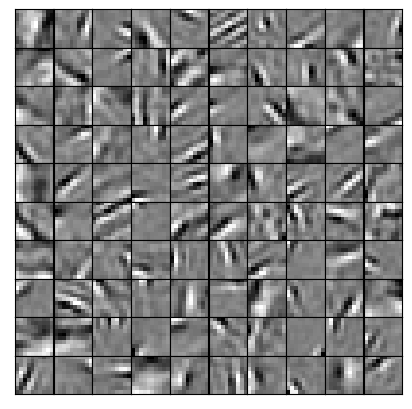

In [372]:
# Show Example (from last one loaded...)
rfs = nets[0].U.weight.T.reshape(results['arg'].n_neuron, results['arg'].size, results['arg'].size).cpu().data.numpy()
fig = plot_rf(rfs, results['arg'].n_neuron, results['arg'].size, showRFs=10**2)

In [203]:
# Measure eigenvectors of images
allImages = []
for img_batch in dataloader:
    allImages.append(torch.flatten(img_batch,1))
allImages = torch.cat(allImages)
imCov = torch.cov(allImages.T)
imEval,imEvec = torch.linalg.eigh(imCov)
imEval,idxEval = torch.sort(imEval, descending=True)
imEvec = imEvec[:,idxEval]
NEV = len(imEval)

# Measure dot product of RFs on eigenvectors and images
beta = []
rfActivation = []
for sn in nets:
    rfs = sn.U.weight.clone().detach().cpu()
    rfs = rfs / torch.norm(rfs,dim=0) # make sure they are normed!
    beta.append(torch.abs(imEvec.T @ rfs))
    rfActivation.append(allImages @ rfs)

# Make summary variables easier to access
beta = torch.stack(beta)
rfActivation = torch.stack(rfActivation)
trackLoss = torch.stack(trackLoss)
alignment = torch.stack(alignment)
noHiLoss = torch.stack(noHiLoss)
noLoLoss = torch.stack(noLoLoss)

# For reference:
# print(beta.shape)
# print(rfActivation.shape)
# print(trackLoss.shape)
# print(alignment.shape)
# print(noHiLoss.shape)

In [328]:
alignment.shape

torch.Size([40, 400, 4000])

In [338]:
cAlignMean = torch.mean(alignment[idxlr],dim=1)
minAlign = torch.min(cAlignMean,dim=1)[0]
maxAlign = torch.max(cAlignMean,dim=1)[0]
align50 = torch.mean(torch.stack((minAlign,maxAlign)),dim=0)
idxAlign50 = torch.argmax(torch.ones(cAlignMean.shape)*(cAlignMean.T<=align50).T,dim=1)
print(minAlign.shape)
print(maxAlign.shape)
print(align50.shape)
print(idxAlign50.shape)
print(minAlign)
print(maxAlign)
print(align50)
print(idxAlign50)

torch.Size([10])
torch.Size([10])
torch.Size([10])
torch.Size([10])
tensor([0.0119, 0.0121, 0.0116, 0.0119, 0.0115, 0.0118, 0.0120, 0.0120, 0.0117,
        0.0118])
tensor([0.0277, 0.0276, 0.0278, 0.0275, 0.0277, 0.0277, 0.0277, 0.0278, 0.0277,
        0.0281])
tensor([0.0198, 0.0199, 0.0197, 0.0197, 0.0196, 0.0198, 0.0198, 0.0199, 0.0197,
        0.0199])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


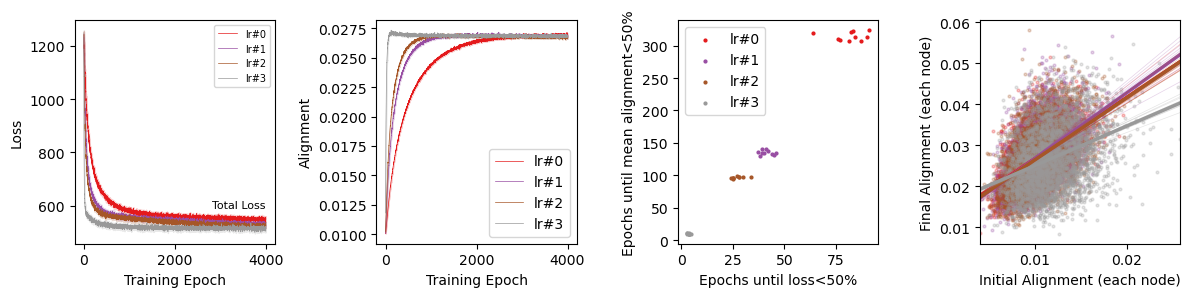

In [381]:
kernelSize=20
missingPoints = (kernelSize-1)
kernel = np.ones(kernelSize)/kernelSize
smooth = lambda x: np.convolve(x,kernel,mode='valid')

numEpoch = trackLoss.shape[1]

fig,ax = plt.subplots(1,4,figsize=(12,3))
cmap = cm.get_cmap('Set1', NLR).colors

# Plot loss trajectories
for lr in range(NLR):
    idxlr = learningRate==lrVals[lr]
    mnLoss = torch.mean(trackLoss[idxlr,:],dim=0)
    seLoss = torch.std(trackLoss[idxlr,:],dim=0)/np.sqrt(np.sum(idxlr))
    mnHiLoss = torch.mean(noHiLoss[idxlr,:],dim=0)
    seHiLoss = torch.std(noHiLoss[idxlr,:],dim=0)/np.sqrt(np.sum(idxlr))
    mnLoLoss = torch.mean(noLoLoss[idxlr,:],dim=0)
    seLoLoss = torch.std(noLoLoss[idxlr,:],dim=0)/np.sqrt(np.sum(idxlr))
    ax[0].plot(range(numEpoch), mnLoss, c=cmap[lr], label=f'lr#{lr}', linewidth=0.5)
    ax[0].fill_between(range(numEpoch), mnLoss+seLoss, mnLoss-seLoss, color=cmap[lr], alpha=0.2)
    # ax[0].plot(range(numEpoch), mnHiLoss, c=cmap[lr], linewidth=0.5)
    # ax[0].fill_between(range(numEpoch), mnHiLoss+seHiLoss, mnHiLoss-seHiLoss, color=cmap[lr], alpha=0.2)
    # ax[0].plot(range(numEpoch), mnLoLoss, c=cmap[lr], linewidth=0.5)
    # ax[0].fill_between(range(numEpoch), mnLoLoss+seLoLoss, mnLoLoss-seLoLoss, color=cmap[lr], alpha=0.2)
    if lr==0:
        endLoss = torch.mean(mnLoss[-10:])
        endHiLoss = torch.mean(mnHiLoss[-10:])
        endLoLoss = torch.mean(mnLoLoss[-10:])
        ax[0].annotate('Total Loss', (numEpoch, endLoss*1.07), ha='right', fontsize=8)
        # ax[0].annotate('w/out most aligned', (numEpoch, endHiLoss*1.07), ha='right', fontsize=8)
        # ax[0].annotate('w/out least aligned', (numEpoch, endLoLoss*1.07), ha='right', fontsize=8)
ax[0].legend(fontsize=7)
ax[0].set_xlabel('Training Epoch')
ax[0].set_ylabel('Loss')

# Plot alignment trajectories
for lr in range(NLR):
    idxlr = learningRate==lrVals[lr]
    seCorrection = np.sqrt(np.sum(idxlr)) * alignment.shape[1]
    mnAlignment = torch.mean(alignment[idxlr,:],dim=(0,1))
    seAlignment = torch.std(alignment[idxlr,:],dim=(0,1))/seCorrection
    ax[1].plot(range(numEpoch), mnAlignment, c=cmap[lr], label=f'lr#{lr}', linewidth=0.5)
    ax[1].fill_between(range(numEpoch), mnAlignment+seAlignment, mnAlignment-seAlignment, color=cmap[lr], alpha=0.2)
ax[1].legend()
ax[1].set_xlabel('Training Epoch')
ax[1].set_ylabel('Alignment')

# Compare 50% points of loss and alignment
for lr in range(NLR):
    idxlr = learningRate==lrVals[lr]
    minLoss = torch.min(trackLoss[idxlr],dim=1)[0]
    maxLoss = torch.max(trackLoss[idxlr],dim=1)[0]
    loss50 = torch.mean(torch.stack((minLoss, maxLoss)),dim=0)
    idxLoss50 = torch.argmax(torch.ones(trackLoss[idxlr].shape)*(trackLoss[idxlr].T<=loss50).T,dim=1)
    cAlignMean = torch.mean(alignment[idxlr],dim=1)
    minAlign = torch.min(cAlignMean,dim=1)[0]
    maxAlign = torch.max(cAlignMean,dim=1)[0]
    align50 = torch.mean(torch.stack((minAlign,maxAlign)),dim=0)
    idxAlign50 = torch.argmax(torch.ones(cAlignMean.shape)*(cAlignMean.T>=align50).T,dim=1)
    ax[2].scatter(idxLoss50, idxAlign50, color=cmap[lr], label=f'lr#{lr}', s=4)
ax[2].set_xlabel('Epochs until loss<50%')
ax[2].set_ylabel('Epochs until mean alignment<50%')
ax[2].legend()

# Plot comparison of loss and similarity
minInit = torch.min(alignment[:,:,0])
maxInit = torch.max(alignment[:,:,0])
for lr in range(NLR):
    idxlr = learningRate==lrVals[lr]
    initAlign = alignment[idxlr,:,0]
    finalAlign = alignment[idxlr,:,-1]
    ax[3].scatter(initAlign,finalAlign,color=cmap[lr], s=4, alpha=0.25)
    for ia,fa in zip(initAlign, finalAlign):
        dmat = torch.stack((torch.ones(len(ia)),ia))
        prms = torch.linalg.pinv(dmat.T) @ fa.T
        ax[3].plot([minInit,maxInit],prms[0]+prms[1]*np.array([minInit,maxInit]),c=cmap[lr],alpha=0.25,linewidth=0.5)
    dmat = torch.stack((torch.ones(torch.numel(initAlign)),torch.flatten(initAlign)))
    prms = torch.linalg.pinv(dmat.T) @ torch.flatten(finalAlign)
    ax[3].plot([minInit,maxInit],prms[0]+prms[1]*np.array([minInit,maxInit]),c=cmap[lr],alpha=1,linewidth=2.5)
ax[3].set_xlim(minInit, maxInit)
ax[3].set_xlabel('Initial Alignment (each node)')
ax[3].set_ylabel('Final Alignment (each node)')

# Make it pretty
plt.tight_layout()

In [349]:
beta.shape

torch.Size([40, 100, 400])

In [361]:
sortBeta = torch.sort(beta[idxlr],dim=1,descending=True)[0]
sortBeta.shape

torch.Size([10, 100, 400])

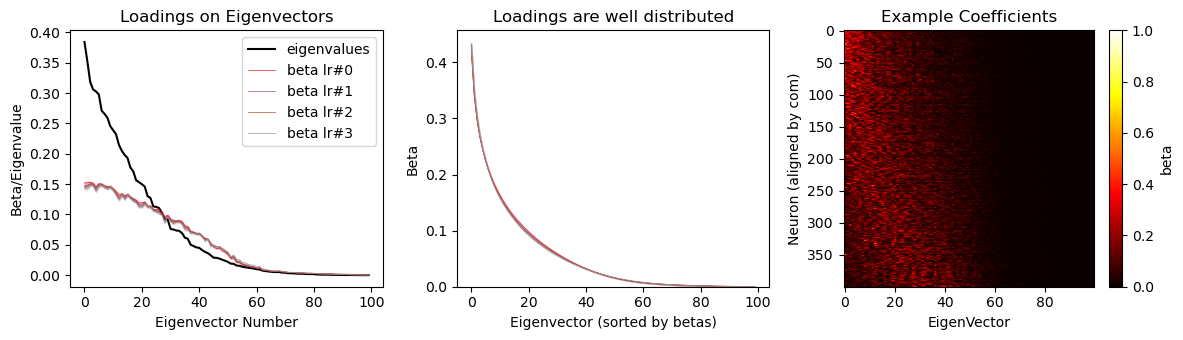

In [371]:
# Make summary plots of betas
fig,ax = plt.subplots(1,3,figsize=(12,3.5))

# Plot betas
ax[0].plot(range(NEV), imEval, c='k', linewidth=1.5, label='eigenvalues')
for lr in range(NLR):
    idxlr = learningRate==lrVals[lr]
    seCorrection = np.sqrt(np.sum(idxlr) * beta.shape[2])
    mnBeta = torch.mean(beta[idxlr],dim=(0,2))
    seBeta = torch.std(beta[idxlr],dim=(0,2))/seCorrection
    ax[0].plot(range(NEV), mnBeta, c=cmap[lr], label=f'beta lr#{lr}', linewidth=0.5)
    ax[0].fill_between(range(NEV), mnBeta+seBeta, mnBeta-seBeta, color=cmap[lr], alpha=0.2)
ax[0].legend()
ax[0].set_xlabel('Eigenvector Number')
ax[0].set_ylabel('Beta/Eigenvalue')
ax[0].set_title('Loadings on Eigenvectors')

# Plot histogram of maximum beta (and second maximum beta) --- or I could do a drop off line plot? Sort each column then plot the mean / error...
for lr in range(NLR):
    idxlr = learningRate==lrVals[lr]
    seCorrection = np.sqrt(np.sum(idxlr)*beta.shape[2])
    sortBeta = torch.sort(beta[idxlr],dim=1,descending=True)[0]
    mnSortBeta = torch.mean(sortBeta,dim=(0,2))
    seSortBeta = torch.std(sortBeta,dim=(0,2))/seCorrection
    ax[1].plot(range(NEV), mnSortBeta, c=cmap[lr], linewidth=0.5, label=f'beta lr#{lr}')
    ax[1].fill_between(range(NEV), mnSortBeta+seSortBeta, mnSortBeta-seSortBeta, color=cmap[lr], alpha=0.2)
ax[1].set_ylim(0)
ax[1].set_xlabel('Eigenvector (sorted by betas)')
ax[1].set_ylabel('Beta')
ax[1].set_title('Loadings are well distributed')

# Plot heatmap of all coefficients (sorted by COM)
exBeta = beta[0]
use2sort = 'eval'
useEvalScale = False
scale = imEval/torch.max(imEval) if useEvalScale else torch.ones(imEval.shape)
comVals = imEval if use2sort=='eval' else np.arange(NEV)
comBeta = (comVals @ exBeta.numpy()) / torch.sum(exBeta * exBeta, dim=0)
idxComBeta = torch.argsort(comBeta,descending=True)
hm=ax[2].imshow(scale*exBeta[:,idxComBeta].T,aspect='auto', cmap='hot', vmin=0, vmax=1)
ax[2].set_xlabel('EigenVector')
ax[2].set_ylabel('Neuron (aligned by com)')
ax[2].set_title('Example Coefficients')
plt.colorbar(hm, ax=ax[2], label='beta')

# # Make it pretty
plt.tight_layout()

# # Compare entropy of betas to similarity
# normBeta = torch.permute(torch.permute(beta, (1,0,2))/torch.sum(beta,dim=1), (1,0,2))
# entropy = -torch.nansum(normBeta * torch.log2(beta),dim=1)
# # plt.hist(entropy);

In [9]:
xr

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [39]:
%timeit np.average(ev1,weights=ev1)
%timeit ev1@ev1/np.sum(ev1)

5.84 µs ± 177 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
2.24 µs ± 39 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


wAvgEv1:0.155, wAvgEv2:0.157, wAvgEv3:0.199


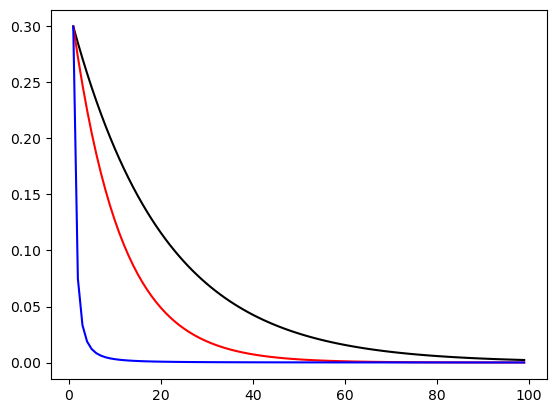

In [ ]:
xr = np.arange(1,100)
pk = 0.3

ev1 = np.exp(-xr/20)
ev2 = 1.1**(-xr)
ev3 = 1/(xr**2)
ev1 = ev1/np.max(ev1)*pk
ev2 = ev2/np.max(ev2)*pk
ev3 = ev3/np.max(ev3)*pk
plt.plot(xr,ev1,c='k')
plt.plot(xr,ev2,c='r')
plt.plot(xr,ev3,c='b')

# plt.xscale('log')
# plt.yscale('log')
print(f"wAvgEv1:{np.average(ev1,weights=ev1):.3f}, wAvgEv2:{np.average(ev2,weights=ev2):.3f}, wAvgEv3:{np.average(ev3,weights=ev3):.3f}")

In [ ]:
stat0,p0 = normaltest(np.random.normal(0,1,rfActivation.shape),axis=0)
stat,p = normaltest(rfActivation,axis=0)

fig,ax = plt.subplots(1,2,figsize=(8,3))
# Plot example activations
ax[0].hist(rfActivation[:,1].numpy(), bins=100)
ax[0].set_xlabel('Activations Ex Unit')
ax[0].set_ylabel('Counts')

# Compare distribution of stats with true normal
ax[1].hist([stat0,stat], bins=50, label=['true normal','activations']);
ax[1].legend()

In [1]:
imEval

NameError: name 'imEval' is not defined

In [ ]:
# At the end of each epoch loop it ran this:
#board.add_scalar('Loss', running_loss / c, e * len(dataloader) + c)
    #if e % 5 == 4:
        # plotting
        #fig = plot_rf(sparse_net.U.weight.T.reshape(arg.n_neuron, arg.size, arg.size).cpu().data.numpy(), arg.n_neuron, arg.size)
        #board.add_figure('RF', fig, global_step=e * len(dataloader) + c)
    #if e % 10 == 9:
        # save checkpoint
        #torch.save(sparse_net, f"../../trained_models/ckpt-{e+1}.pth")

# And ran this at the end end
#torch.save(sparse_net, f"../../trained_models/ckpt-{e+1}.pth")